In [2]:
import os
import numpy as np
import json
import wandb
from transformers import AutoTokenizer
from experiment_lib import *
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import statistics

load_dotenv()

True

In [13]:
# path to the (pretraining) dataset of the model
DATASET_DIR = "europarl"
# file name of text version of the dataset
DATASET_NAME = "europarl-v7.nl-en"
# language of the setup
LANGUAGE = "en"
# target directory for the csv files
SOURCE_DIR = "./datasets"
# desired token length of examples
EXAMPLE_TOKEN_LEN = 100
# target file name for the byte off set csv files
BYTE_OFFSET_FILE = DATASET_NAME + "." + LANGUAGE + ".csv"
PREFIX_LEN = 50
NUM_TRIALS = 100
EXAMPLE_TOKEN_LEN = 100
ROOT_DIR = "tmp"

model_size = "125M"

EXPERIMENT_NAME = LANGUAGE + "-" + str(EXAMPLE_TOKEN_LEN) + "-" + str(NUM_TRIALS) + "-" + model_size


model = "EleuterAI/gpt-neo-" + model_size


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/annavisman/.netrc


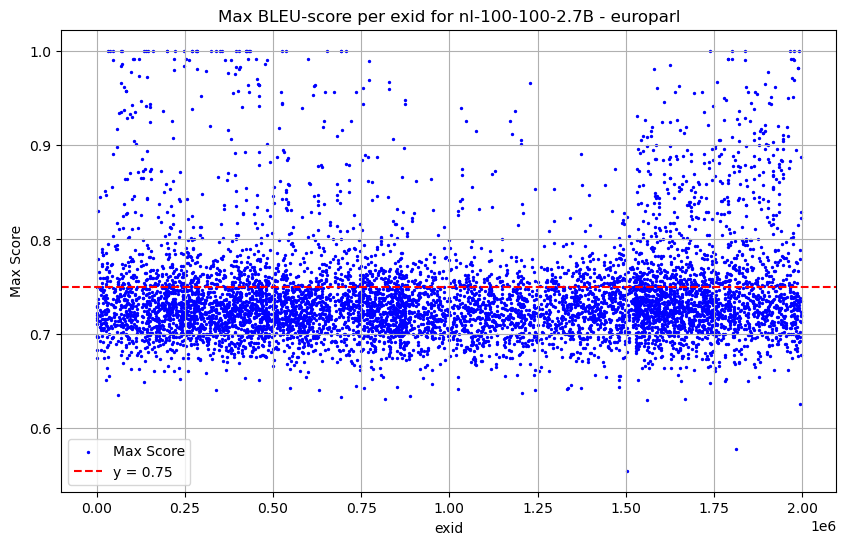

In [21]:
wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key)

# Initialize wandb
wandb.init(
    project="thesis-llm-privacy",
    name="Plot max. BLEU Score - " + EXPERIMENT_NAME + " - " + model,
    config={
        "experiment_name": EXPERIMENT_NAME,
        "dataset": DATASET_DIR,
        "language": LANGUAGE,
        "token_len": EXAMPLE_TOKEN_LEN,
        "prefix_len": PREFIX_LEN,
        "num_trials": NUM_TRIALS,
    },
)

path = os.path.join(ROOT_DIR, DATASET_DIR, LANGUAGE, EXPERIMENT_NAME, "scores/sorted_compl_bleu_scores.jsonl")
# Load JSON data
data = []
with open(path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Extract the maximum score for each exid
max_scores = [(int(entry['exid']), entry['scores'][0]['score']) for entry in data]

# Sort by exid
max_scores.sort(key=lambda x: int(x[0]))

# Separate the exid and scores for plotting
exids, scores = zip(*max_scores)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(exids, scores, color='b', label='Max Score', s=2)
ax.axhline(y=0.75, color='r', linestyle='--', label='y = 0.75')

ax.set_xlabel('exid')
ax.set_ylabel('Max Score')
ax.set_title('Max BLEU-score per exid for ' + EXPERIMENT_NAME + ' - ' + DATASET_DIR)
ax.legend()
ax.grid(True)

# Log the plot to wandb
wandb.log({"Max Scores Plot": wandb.Image(fig)})

# Show the plot
plt.show()

# Finish the wandb run
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/annavisman/.netrc


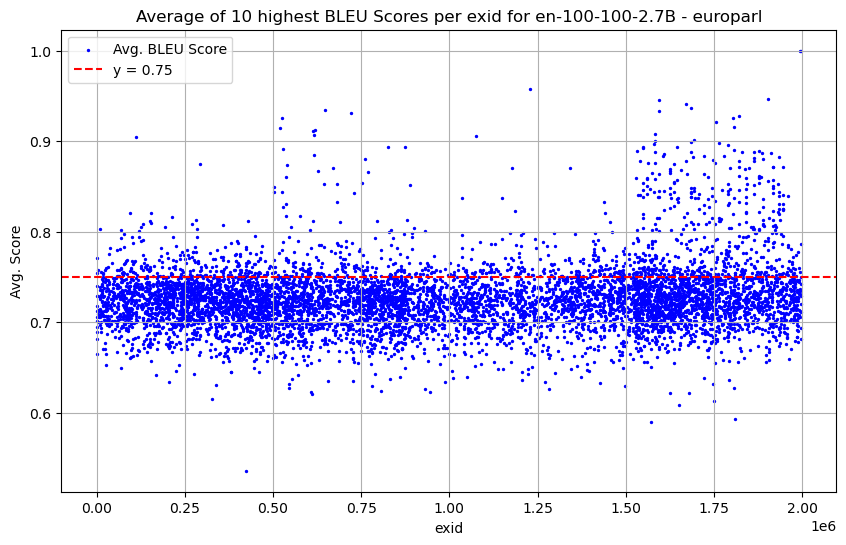

In [36]:
# Average of top 10 bleu scores for each exid
wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key)

# Initialize wandb
wandb.init(
    project="thesis-llm-privacy",
    name="Avg. of 10 highest BLEU scores - " + EXPERIMENT_NAME + " - " + model,
    config={
        "experiment_name": EXPERIMENT_NAME,
        "dataset": DATASET_DIR,
        "language": LANGUAGE,
        "token_len": EXAMPLE_TOKEN_LEN,
        "prefix_len": PREFIX_LEN,
        "num_trials": NUM_TRIALS,
    },
)

path = os.path.join(ROOT_DIR, DATASET_DIR, LANGUAGE, EXPERIMENT_NAME, "scores/sorted_compl_bleu_scores.jsonl")
# Load JSON data
data = []
with open(path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Extract average of 10 highest scores for each exid
max_scores = [(int(entry['exid']), statistics.mean(entry['scores'][i]['score'] for i in range(min(10, len(entry['scores']))))) for entry in data]

# Sort by exid
max_scores.sort(key=lambda x: int(x[0]))

# Separate the exid and scores for plotting
exids, scores = zip(*max_scores)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(exids, scores, color='b', label='Avg. BLEU Score', s=2)
ax.axhline(y=0.75, color='r', linestyle='--', label='y = 0.75')

ax.set_xlabel('exid')
ax.set_ylabel('Avg. Score')
ax.set_title('Average of 10 highest BLEU Scores per exid for ' + EXPERIMENT_NAME + ' - ' + DATASET_DIR)
ax.legend()
ax.grid(True)

# Log the plot to wandb
wandb.log({"Avg Scores Plot": wandb.Image(fig)})

# Show the plot
plt.show()

# Finish the wandb run
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/annavisman/.netrc


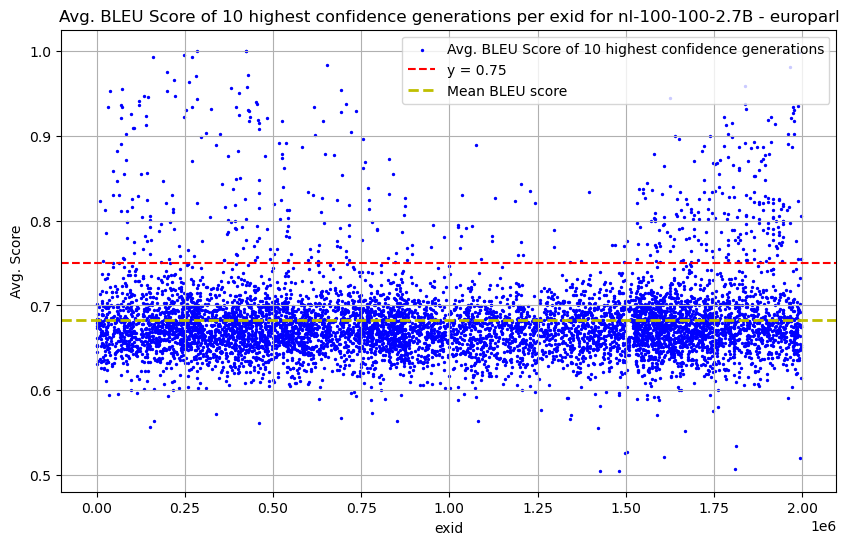

In [20]:
# Average bleu score of 10 highest confidence generations for each exid
wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key)

# Initialize wandb
wandb.init(
    project="thesis-llm-privacy",
    name="Avg. BLEU score of 10 highest confidence scores - " + EXPERIMENT_NAME + " - " + model,
    config={
        "experiment_name": EXPERIMENT_NAME,
        "dataset": DATASET_DIR,
        "language": LANGUAGE,
        "token_len": EXAMPLE_TOKEN_LEN,
        "prefix_len": PREFIX_LEN,
        "num_trials": NUM_TRIALS,
    },
)

losses_path = os.path.join(ROOT_DIR, DATASET_DIR, LANGUAGE, EXPERIMENT_NAME, "losses/decoded/sorted_compl_losses.jsonl")
# grab first 10 highest confidence scores for each exid
trials = []
with open(losses_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        exid = data['exid']
        # grab last 10
        losses = data['losses'][-10:]
        trial_nums = [loss['trial'] for loss in losses]
        # trial numbers with highest confidence scores for each exid
        trials.append((exid, trial_nums))

# Create a dictionary from trials for easy lookup
trials_dict = {exid: trial_nums for exid, trial_nums in trials}

score_path = os.path.join(ROOT_DIR, DATASET_DIR, LANGUAGE, EXPERIMENT_NAME, "scores/sorted_compl_bleu_scores.jsonl")
# Load JSON data
scores = []
with open(score_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        exid = data['exid']
        if exid in trials_dict:
            # Get the trial numbers for this exid
            trial_nums = trials_dict[exid]
            # Get the scores for these trial numbers
            trial_scores = [score for score in data['scores'] if score['trial'] in trial_nums]
            scores.append((exid, trial_scores))

# Extract average of 10 highest scores for each exid
max_scores = [(int(entry[0]), statistics.mean(score['score'] for score in entry[1])) for entry in scores]

# Sort by exid
max_scores.sort(key=lambda x: int(x[0]))

import statistics

# Extract the scores
scores = [score for exid, score in max_scores]

# Calculate the average score
average_score = statistics.mean(scores)

# Separate the exid and scores for plotting
exids, scores = zip(*max_scores)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(exids, scores, color='b', label='Avg. BLEU Score of 10 highest confidence generations', s=2)
ax.axhline(y=0.75, color='r', linestyle='--', label='y = 0.75')
ax.axhline(y=average_score, color='y', linestyle='--', linewidth=2, label='Mean BLEU score')

ax.set_xlabel('exid')
ax.set_ylabel('Avg. Score')
ax.set_title('Avg. BLEU Score of 10 highest confidence generations per exid for ' + EXPERIMENT_NAME + ' - ' + DATASET_DIR)
ax.legend()
ax.grid(True)

# Log the plot to wandb
wandb.log({"Avg Highest Confidence Scores Plot": wandb.Image(fig)})

# Show the plot
plt.show()

# Finish the wandb run
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/annavisman/.netrc


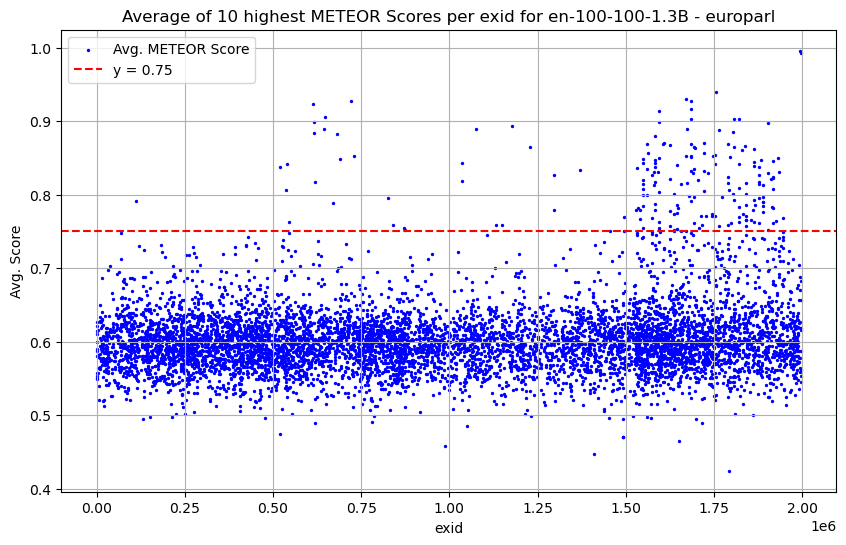

In [15]:
# Average of top 10 bleu scores for each exid
wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key)

# Initialize wandb
wandb.init(
    project="thesis-llm-privacy",
    name="Avg. of 10 highest METEOR scores - " + EXPERIMENT_NAME + " - " + model,
    config={
        "experiment_name": EXPERIMENT_NAME,
        "dataset": DATASET_DIR,
        "language": LANGUAGE,
        "token_len": EXAMPLE_TOKEN_LEN,
        "prefix_len": PREFIX_LEN,
        "num_trials": NUM_TRIALS,
    },
)

path = os.path.join(ROOT_DIR, DATASET_DIR, LANGUAGE, EXPERIMENT_NAME, "meteor_scores/sorted_compl_meteor_scores.jsonl")
# Load JSON data
data = []
with open(path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Extract average of 10 highest scores for each exid
max_scores = [(int(entry['exid']), statistics.mean(entry['scores'][i]['score'] for i in range(min(10, len(entry['scores']))))) for entry in data]

# Sort by exid
max_scores.sort(key=lambda x: int(x[0]))

# Separate the exid and scores for plotting
exids, scores = zip(*max_scores)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(exids, scores, color='b', label='Avg. METEOR Score', s=2)
ax.axhline(y=0.75, color='r', linestyle='--', label='y = 0.75')

ax.set_xlabel('exid')
ax.set_ylabel('Avg. Score')
ax.set_title('Average of 10 highest METEOR Scores per exid for ' + EXPERIMENT_NAME + ' - ' + DATASET_DIR)
ax.legend()
ax.grid(True)

# Log the plot to wandb
wandb.log({"Avg METEOR Scores Plot": wandb.Image(fig)})

# Show the plot
plt.show()

# Finish the wandb run
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


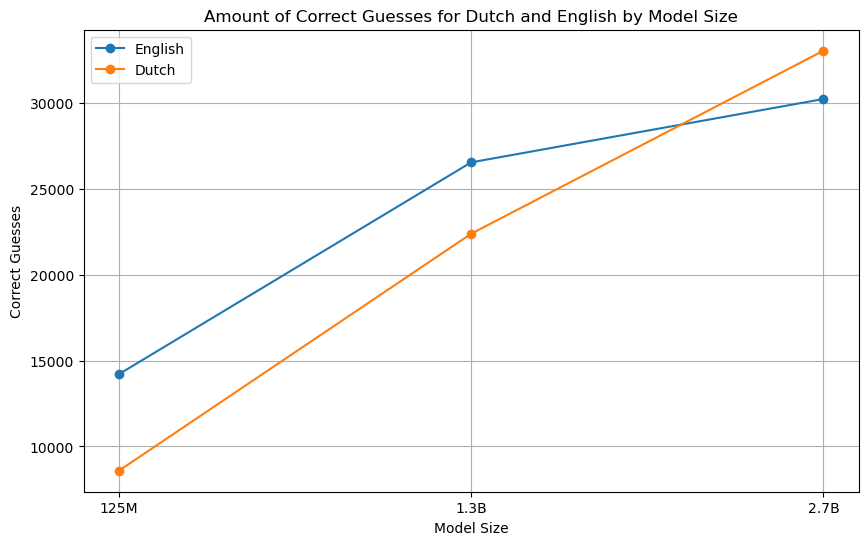

In [24]:
# Get the Wandb API key from environment variable
wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key)

# Initialize Wandb
wandb.init(
    project="thesis-llm-privacy",
    name="Number of correct guesses for model sizes and languages - " + DATASET_DIR,
    config={
        "dataset": DATASET_DIR,
        "language": LANGUAGE,
        "token_len": EXAMPLE_TOKEN_LEN,
        "prefix_len": PREFIX_LEN,
        "num_trials": NUM_TRIALS,
    },
)

base = os.path.join(ROOT_DIR, DATASET_DIR)
model_sizes = ["125M", "1.3B", "2.7B"]
languages = ["en", "nl"]

en_scores = []
nl_scores = []

for lang in languages:
    for size in model_sizes:
        acc_file = os.path.join(base, lang, f"{lang}-{EXAMPLE_TOKEN_LEN}-{NUM_TRIALS}-{size}", "accuracy.jsonl")
        with open(acc_file, 'r') as file:
            # Load the first line
            data = json.loads(file.readline())

            # Get the number of correct guesses
            correct = data['num_correct']
            exact = data['num_exact_match']
            if lang == "en":
                en_scores.append((size, correct, exact))
            if lang == "nl":
                nl_scores.append((size, correct, exact))

# Convert scores to a format suitable for Wandb Table
table = wandb.Table(columns=["Model Size", "Correct Guesses", "Exact Matches", "Language"])
for size, correct, exact in en_scores:
    table.add_data(size, correct, exact, "English")
for size, correct, exact in nl_scores:
    table.add_data(size, correct, exact, "Dutch")

# Log the table to Wandb
wandb.log({"Correct Guesses Comparison": table})

# Create plot
wandb.log({
    "Correct guesses comparison": wandb.plot.line_series(
        xs=[[size] for size, _, _ in en_scores] + [[size] for size, _, _ in nl_scores],
        ys=[[correct] for _, correct, _ in en_scores] + [[correct] for _, correct, _ in nl_scores],
        keys=["English"] * len(en_scores) + ["Dutch"] * len(nl_scores),
        title="Amount of Correct Guesses for Dutch and English by Model Size",
    )
})

# Plotting using matplotlib
fig = plt.figure(figsize=(10, 6))
plt.plot([size for size, _, _ in en_scores], [correct for _, correct, _ in en_scores], label='English', marker='o')
plt.plot([size for size, _, _ in nl_scores], [correct for _, correct, _ in nl_scores], label='Dutch', marker='o')
plt.xlabel('Model Size')
plt.ylabel('Correct Guesses')
plt.title('Amount of Correct Guesses for Dutch and English by Model Size')
plt.legend()
plt.grid(True)

# Log the figure to Wandb
wandb.log({"Correct Guesses Comparison Figure": wandb.Image(fig)})

# Show the plot
plt.show()


# Finish the Wandb run
wandb.finish()